# Installs and imports

In [3]:
!pip3 install lxml simpy html5lib

In [0]:
import matplotlib.pylab as plt
from numpy.random import choice
import pandas as pd
from scipy.stats import poisson
import simpy
import seaborn as sns

# Blood-related info

In [0]:
def get_blood_params():
    _url = '''https://pt.wikipedia.org/wiki/Grupo_sangu%C3%ADneo'''
    dfs = pd.read_html(_url)

    tmp = dfs[0]
    tmp.columns = tmp.iloc[0]
    tmp = tmp[tmp['País'] == 'Brasil[9]']
    tmp = tmp.drop(['País'], axis=1).reset_index(drop=True)
    blood_types = tmp.columns.tolist()
    blood_types_p = [float(x.replace('%', ''))
                     for x in tmp.iloc[0].values]
    total = sum(blood_types_p)
    blood_types_p = [x/total for x in blood_types_p]

    tmp = dfs[1]
    blood_types = [x.replace('−', '-') for x in tmp.iloc[1].dropna()]
    compatibility_matrix = tmp.iloc[2:,1:].values
    compatibility_matrix = pd.DataFrame(compatibility_matrix,
                                        columns=blood_types,
                                        index=blood_types)\
                             .applymap(lambda x: True if x == 'Sim' else False)
    compatibility_matrix.columns.name = 'donor'
    compatibility_matrix.index.name = 'patient'

    return blood_types, blood_types_p, compatibility_matrix

In [6]:
blood_types, blood_types_p, compatibility_matrix = get_blood_params()

KeyError: ignored

### Frequencies

In [0]:
pd.DataFrame(blood_types_p,
             index=blood_types,
             columns=['prob'])\
  .sort_values(by='prob', ascending=False).T

,O-,O+,A-,B+,B-,AB-,A+,AB+
prob,0.375,0.3125,0.09375,0.09375,0.041667,0.041667,0.036458,0.005208


In [0]:
def blood_type_sampler():
    return choice(blood_types, 1, p=blood_types_p)[0]

### Compatibility

In [0]:
compatibility_matrix

donor,O-,O+,A-,A+,B-,B+,AB-,AB+
patient,,,,,,,,
O-,True,False,False,False,False,False,False,False
O+,True,True,False,False,False,False,False,False
A-,True,False,True,False,False,False,False,False
A+,True,True,True,True,False,False,False,False
B-,True,False,False,False,True,False,False,False
B+,True,True,False,False,True,True,False,False
AB-,True,False,True,False,True,False,True,False
AB+,True,True,True,True,True,True,True,True


In [0]:
def is_compatible(receiver_type, donor_type):
    return compatibility_matrix.loc[receiver_type, donor_type]

# Parameters

### Overall

In [0]:
nsteps = 1000
expiration = 30

### Patients inflow

In [0]:
patients_arrival_dist = poisson(2)

### Donors inflow

In [0]:
donors_arrival_dist = poisson(3/2)

# Simulation objects

### Blood Bags

In [0]:
class BloodBag(object):
    def __init__(self, expiration, blood_type):
        self.expiration = expiration
        self.blood_type = blood_type

### Donors

In [0]:
amount_donated = 0
donor_types = []
def donor(env, blood_bags, expiration=expiration):
    global amount_donated
    blood_type = blood_type_sampler()
    blood_bag = BloodBag(expiration=env.now + expiration,
                         blood_type=blood_type)
    yield blood_bags.put(blood_bag)
    amount_donated += 1
    donor_types.append((env.now, blood_type))
    
def generate_donors(env, blood_bags,
                    dist=donors_arrival_dist):
    while True:
        env.process(donor(env, blood_bags))
        yield env.timeout(dist.rvs())

### Patients

In [0]:
time_waited = []
amount_received = 0
def patient(env, blood_bags):
    global amount_received
    blood_type = blood_type_sampler()
    criteria = lambda x: x.expiration > env.now and\
                         is_compatible(blood_type, x.blood_type)
    start = env.now
    yield blood_bags.get(criteria)
    time_waited.append((env.now - start, blood_type))
    amount_received += 1
    
def generate_patients(env, blood_bags,
                      dist=patients_arrival_dist):
    while True:
        env.process(patient(env, blood_bags))
        yield env.timeout(dist.rvs())

### Observer

In [0]:
obs_blood = []
def observer(env, blood_bags):
    counter = 0
    while True:
        amount_in_bank = {blood_type: 0
                          for blood_type in blood_types}
        for blood_bag in blood_bags.items:
            if not blood_bag.expiration >= env.now:
                continue
            blood_type = blood_bag.blood_type
            amount_in_bank[blood_type] += 1
        obs_blood.append(amount_in_bank)
        yield env.timeout(1)

# Simulation

In [0]:
env = simpy.Environment()
blood_bags = simpy.FilterStore(env)
env.process(generate_patients(env, blood_bags))
env.process(generate_donors(env, blood_bags))
env.process(observer(env, blood_bags))
env.run(until=nsteps)

# Results

In [0]:
sns.set_palette(sns.color_palette("hls", len(blood_types)))

### Overall

In [0]:
print(f'amount_donated: {amount_donated}')
print(f'amount_used: {amount_received}')
amount_in_bank = sum([blood_bag.expiration >= env.now
                      for blood_bag in blood_bags.items])
amount_expired = len(blood_bags.items) - amount_in_bank
print(f'amount_expired: {amount_expired}')
print(f'amount_in_bank: {amount_in_bank}')

amount_donated: 664
amount_used: 497
amount_expired: 156
amount_in_bank: 11


### Blood bank levels

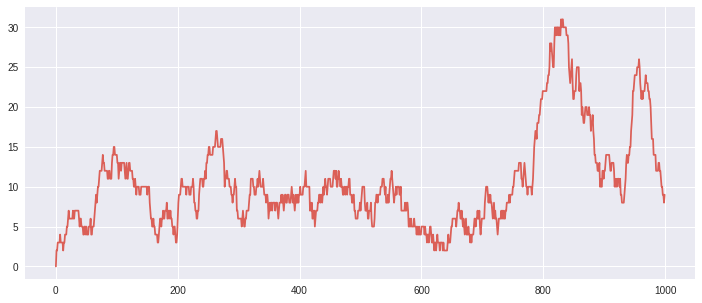

In [0]:
obs_blood = pd.DataFrame(obs_blood)
obs_blood.sum(axis=1).rename('Total valid').plot(figsize=(12, 5));

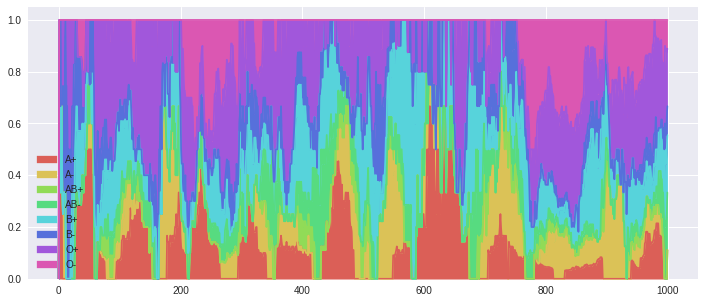

In [0]:
obs_blood.div(obs_blood.sum(axis=1), axis=0)\
         .plot(kind='area', stacked=True, figsize=(12, 5));

### Patient related results

In [0]:
time_waited = pd.DataFrame(time_waited, columns=['Waited', 'Blood Type'])
time_waited_gbo = time_waited.groupby('Blood Type')['Waited']

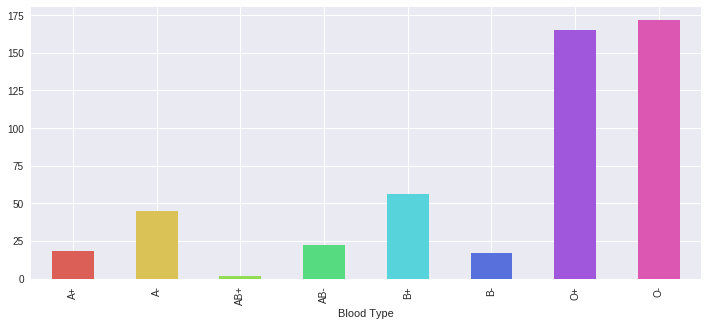

In [0]:
time_waited_gbo.count().plot.bar(figsize=(12, 5));

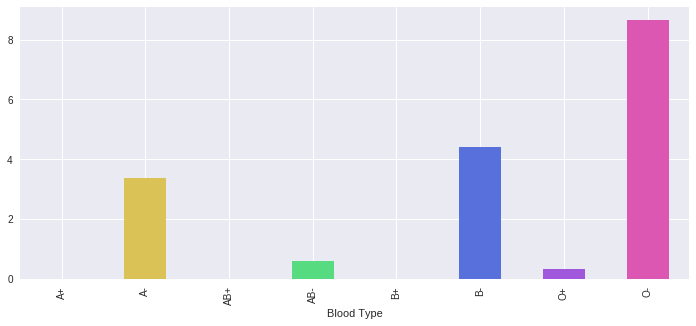

In [0]:
time_waited_gbo.mean().plot.bar(figsize=(12, 5));

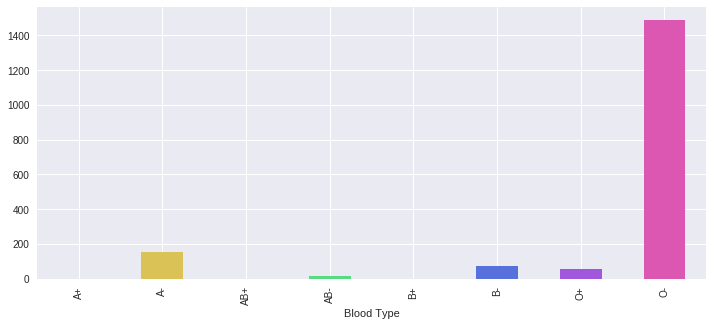

In [0]:
time_waited_gbo.sum().plot.bar(figsize=(12, 5));